In [ ]:
#|echo: false
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from fastcore.all import *

## Get data

In [ ]:
explore_types = ['frutas', 'lacteos', 'verduras', 'embutidos', 'panaderia', 'desayuno', 'congelados', 'abarrotes',
                 'aves', 'carnes', 'pescados']

In [ ]:
#|tbl-cap: Data table
path = Path('../../output')
csv_files = L(path.glob('*.csv')).filter(lambda o: os.stat(o).st_size>0)
pat_store = re.compile('(.+)\_\d+')
pat_date = re.compile('.+\_(\d+)')
df = (
    pd.concat([pd.read_csv(o).assign(store=pat_store.match(o.stem)[1], date=pat_date.match(o.stem)[1])
               for o in csv_files])
    .pipe(lambda df: df.assign(
        name=df.name.str.lower(),
        sku=df.id.where(df.sku.isna(), df.sku).astype(int),
        date=pd.to_datetime(df.date)
    ))
    .drop('id', axis=1)
    .loc[lambda d: d.category.str.contains('|'.join(explore_types))]
)
df.sample(3)

,brand,uri,name,price,category,store,date,sku
2694,MOLINOS DEL MUNDO,https://www.plazavea.com.pe/pan-de-queso-molin...,pan de queso molinos del mundo bolsa 500g,27.49,https://www.plazavea.com.pe/panaderia-y-pastel...,plaza_vea,2022-12-01,43207
106,LA FLORENCIA,NaN,keke marmoleado la florencia,10.50,https://www.plazavea.com.pe/panaderia-y-pastel...,plaza_vea,2022-12-19,46475
6674,COMPASS,NaN,mermelada compass fresa pote 350g,6.90,https://www.plazavea.com.pe/desayunos,plaza_vea,2022-11-03,49952


In [ ]:
top_changes = (df
 .groupby(['store','sku'], as_index=False)
 .price
 .agg('std')
 .query('price>0')
 .sort_values('price', ascending=False)
)
top_changes.head()

,store,sku,price
8849,plaza_vea,10039597,22.721922
11384,plaza_vea,10734129,19.910084
7640,plaza_vea,43433,18.435330
8902,plaza_vea,10043433,15.242047
10535,plaza_vea,10523088,15.000000


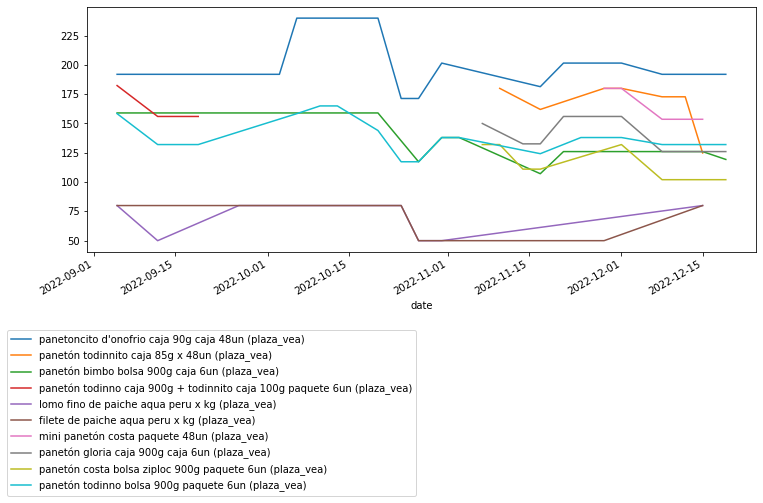

In [ ]:
#|fig-cap: Top changes
fig,ax = plt.subplots(figsize=(12,5))
for _,row in top_changes.head(10).iterrows():
    (df
     .query('store==@row.store and sku==@row.sku')
     .assign(name=lambda d: d.name+' ('+d.store+')')
     .pipe(lambda d: d.plot(x='date', y='price', label=d.name.iloc[0], ax=ax))
    )
ax.legend(bbox_to_anchor=(0.5,-0.3));

In [ ]:
top_drops = (df
 .sort_values('date')
 .pipe(lambda d: d.assign(**d
     .groupby(['store','sku'], as_index=False).price
     .transform(lambda d: d.rolling(3).mean())
     .loc[:,['price']]
 ))
 .dropna()
 .groupby(['store','sku'], as_index=False)
 .price
 .agg(['first','last'])
 .assign(diff=lambda d: d['last']-d['first'])
 .reset_index()
 .sort_values('diff')
)
top_drops.head()

,store,sku,first,last,diff
6058,plaza_vea,43433,159.0,123.763333,-35.236667
7847,plaza_vea,10523087,79.9,59.900000,-20.000000
6793,plaza_vea,10040970,34.9,17.450000,-17.450000
8369,plaza_vea,10734129,174.0,156.800000,-17.200000
7955,plaza_vea,10571894,44.9,29.900000,-15.000000


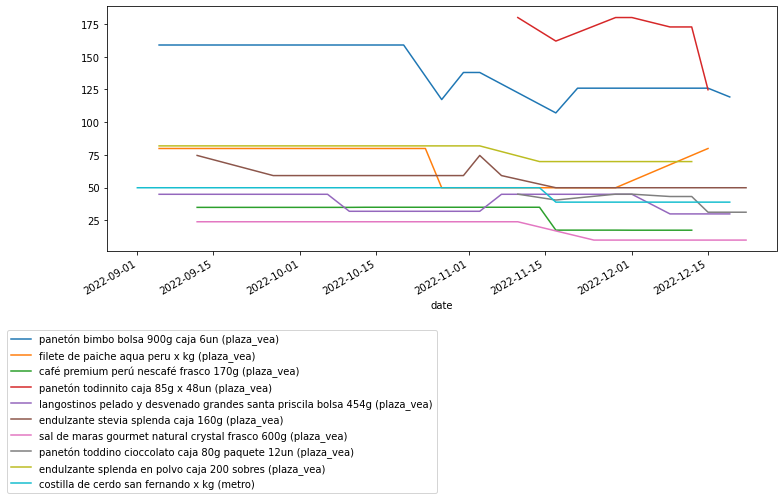

In [ ]:
#|fig-cap: Top drops
fig,ax = plt.subplots(figsize=(12,5))
for _,row in top_drops.head(10).iterrows():
    (df
     .query('store==@row.store and sku==@row.sku')
     .assign(name=lambda d: d.name+' ('+d.store+')')
     .pipe(lambda d: d.plot(x='date', y='price', label=d.name.iloc[0], ax=ax))
    )
ax.legend(bbox_to_anchor=(0.5,-0.3));

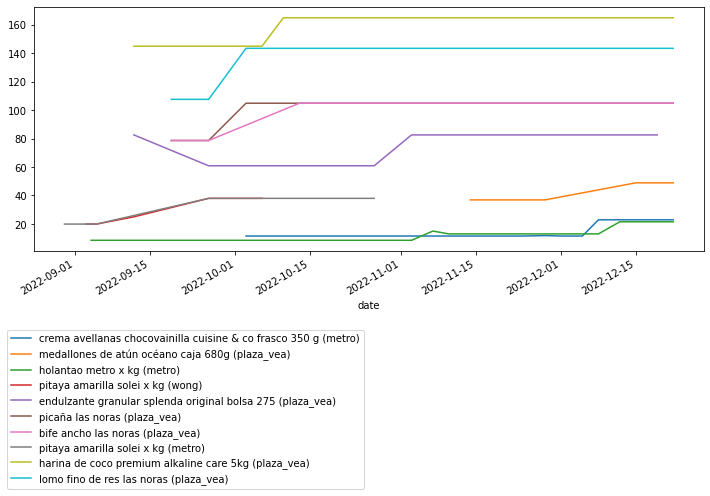

In [ ]:
#|fig-cap: Top increases
fig,ax = plt.subplots(figsize=(12,5))
for _,row in top_drops.tail(10).iterrows():
    (df
     .query('store==@row.store and sku==@row.sku')
     .assign(name=lambda d: d.name+' ('+d.store+')')
     .pipe(lambda d: d.plot(x='date', y='price', label=d.name.iloc[0], ax=ax))
    )
ax.legend(bbox_to_anchor=(0.5,-0.3));

In [ ]:
#|echo: false
#|output: false
names = df.name[df.name.str.contains(r'(?=.*pollo)(?=.*entero).*') &
                ~df.name.str.contains(r'marinado|aderezo')].unique().tolist()
names

['pollo entero light  x kg',
 'pollo entero fresco metro x kg',
 'pollo entero\xa0artisan\xa0libre de antibióticos x kg',
 'pollo entero con menudencia x kg',
 'pollo entero sin menudencia x kg']

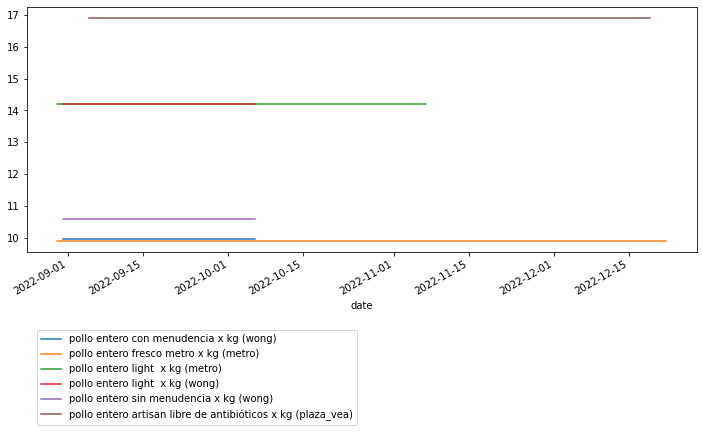

In [ ]:
#|fig-cap: Pollo
fig,ax = plt.subplots(figsize=(12,5))
for n,d in df.loc[df.name.isin(names)].assign(name=lambda d: d.name+' ('+d.store+')').groupby('name'):
    d.plot(x='date', y='price', label=n, ax=ax)
ax.legend(bbox_to_anchor=(0.5,-0.3));

In [ ]:
#|echo: false
#|output: false
names = df.name[df.name.str.contains(r'palta') &
                ~df.name.str.contains(r'shampoo|humectante|vino|salsa|acondicionador|aceite')].unique().tolist()
names

['palta nava metro x kg',
 'palta hass natifrut x kg',
 'palta fuerte metro x kg',
 'palta madura cremosita x kg',
 'palta hass madura la caserita empaque 500g',
 'palta fuerte',
 'palta naval x kg',
 "palta fuerte bell's madura",
 'palta fuerte madura empacada x kg',
 'palta hass orgánica 1kg',
 'palta fuerte verde x kg',
 'palta fuerte x kg',
 'palta nava x kg',
 'palta fuerte malla 1kg z',
 'palta hass']

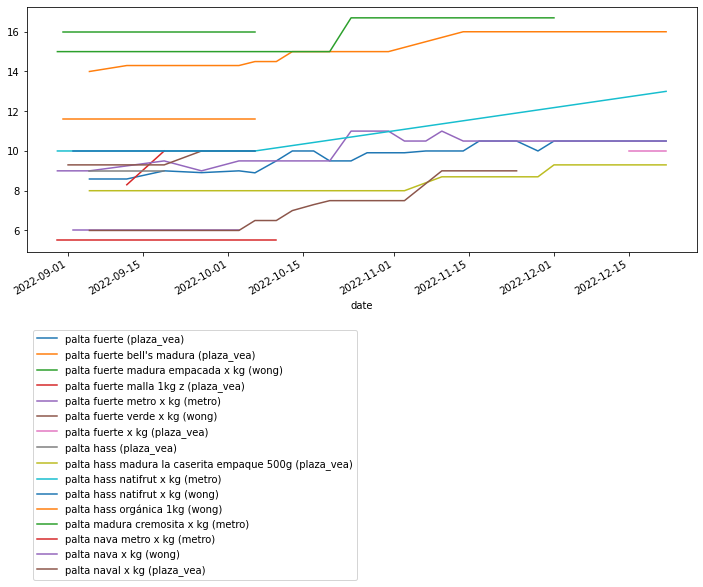

In [ ]:
#|fig-cap: Palta
fig,ax = plt.subplots(figsize=(12,5))
for n,d in df.loc[df.name.isin(names)].assign(name=lambda d: d.name+' ('+d.store+')').groupby('name'):
    d.plot(x='date', y='price', label=n, ax=ax)
ax.legend(bbox_to_anchor=(0.5,-0.3));

In [ ]:
#|echo: false
#|output: false
names = df.name[df.name.str.contains(r'(?=.*aceite)(?=.*vegetal).*') &
                ~df.name.str.contains(r'atun|atún|pack|filete|caballa|tacos|sardinas')].unique().tolist()
names

['aceite vegetal cocinero botella 5 litros',
 'aceite vegetal nicolini 900ml',
 'aceite vegetal primor clásico 1.8l',
 'aceite vegetal metro 900ml',
 'aceite vegetal deleite premium 900ml',
 'aceite vegetal máxima 900ml',
 'aceite vegetal primor clásico 900ml',
 'aceite vegetal cocinero 900ml',
 'aceite vegetal primor corazón 900ml',
 'aceite vegetal primor premium 900ml',
 'aceite vegetal de soya del cielo botella 1l',
 'aceite vegetal primor premium botella 900ml',
 'aceite vegetal primor botella 900ml',
 'aceite vegetal nicolini botella 900ml',
 "aceite vegetal bell's botella 900ml",
 "aceite vegetal bell's botella 900ml paquete x 12un",
 'aceite vegetal cocinero botella 900ml',
 'aceite vegetal mazola canola y girasol spray 142g',
 'aceite vegetal deleite botella 900ml',
 'aceite vegetal primor botella 1.8l',
 'anchoveta en aceite vegetal a1 lata 125g',
 'aceite vegetal del cielo soya bidón 5l',
 'aceite vegetal cil botella 900ml',
 "aceite vegetal bell's galonera 5l",
 'aceite veg

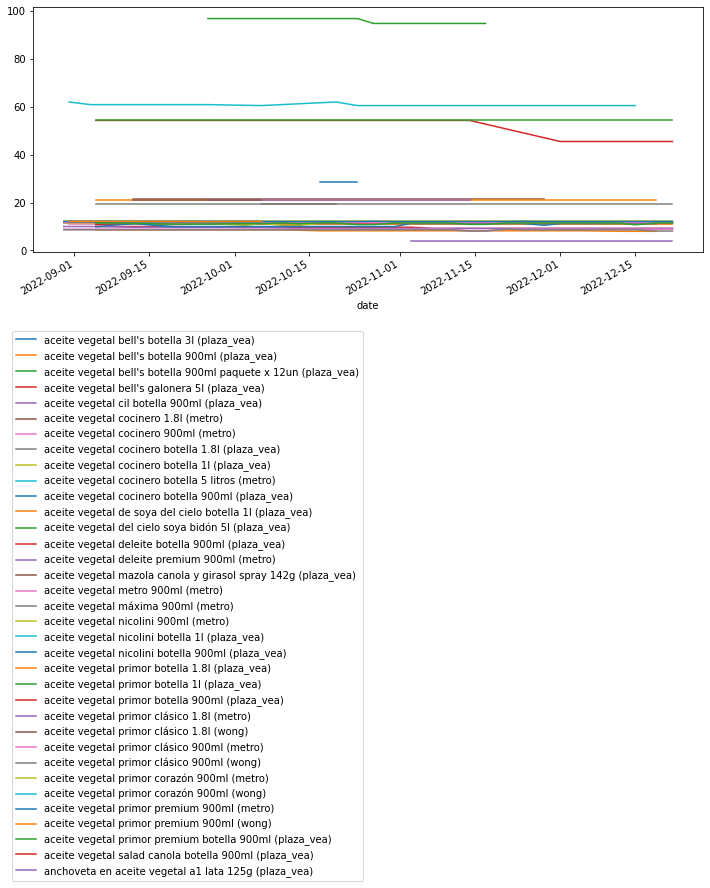

In [ ]:
#|fig-cap: Aceite vegeta
fig,ax = plt.subplots(figsize=(12,5))
for n,d in df.loc[df.name.isin(names)].assign(name=lambda d: d.name+' ('+d.store+')').groupby('name'):
    d.plot(x='date', y='price', label=n, ax=ax)
ax.legend(bbox_to_anchor=(0.5,-0.3));